In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices(('GPU')))

2023-12-11 12:07:25.913312: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 12:07:25.938102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 12:07:25.938125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 12:07:25.938795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 12:07:25.942842: I tensorflow/core/platform/cpu_feature_guar

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-11 12:07:26.681570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 12:07:26.701398: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 12:07:26.701436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

#### Get MNIST Data

In [10]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


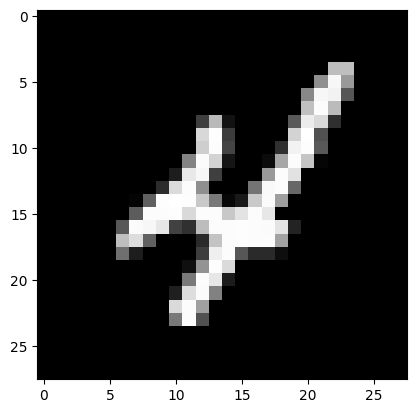

In [11]:
from matplotlib import pyplot as plt
plt.imshow(x_train[9], cmap='gray')

In [12]:
x_train.shape

(60000, 28, 28)

In [13]:
x_train, x_test = x_train/255.0, x_test/255.0

# Add channels
x_train = x_train[..., tf.newaxis].astype('float32')
# This can also be acheived by tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)

2023-12-11 12:37:58.101140: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 12:37:58.101213: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 12:37:58.101228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 12:37:58.236158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 12:37:58.236204: I external/local_xla/xla/stream_executor

In [16]:
# Shuffle Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

#### Build model with model subclassing API

In [24]:
class MnistModel(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)
    
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Create model instance
model = MnistModel()

In [25]:
# Chose optimizer and loss function

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [26]:
# Select metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#### Model training with GradientTape

In [27]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=False) # No need to true on training here.
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


In [28]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training='False')
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [29]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # Reset metrics at the start of next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Loss: 0.13711389899253845, Accuracy: 95.91000366210938, Test Loss: 0.056559737771749496, Test Accuracy: 98.1500015258789
Epoch 2, Loss: 0.043457500636577606, Accuracy: 98.66333770751953, Test Loss: 0.05533600598573685, Test Accuracy: 98.23999786376953
Epoch 3, Loss: 0.022723659873008728, Accuracy: 99.24500274658203, Test Loss: 0.05137253925204277, Test Accuracy: 98.41999816894531
Epoch 4, Loss: 0.01328953541815281, Accuracy: 99.55333709716797, Test Loss: 0.0633229911327362, Test Accuracy: 98.22000122070312
Epoch 5, Loss: 0.008758103474974632, Accuracy: 99.70999908447266, Test Loss: 0.054138507694005966, Test Accuracy: 98.47999572753906
